# Calculate buoyancy frequency profiles, WKB limit and ultimately vertical modes

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        with dask.config.set({"distributed.scheduler.worker-saturation": 1.0,
                      "distributed.nanny.pre-spawn-environ.MALLOC_TRIM_THRESHOLD_": 0,
                    "logging.distributed": "error"}):
            client = Client()
        print(client)
    return client

client = startdask()
client

<Client: 'tcp://127.0.0.1:43633' processes=7 threads=28, memory=112.00 GiB>


<Client: 'tcp://127.0.0.1:43633' processes=7 threads=28, memory=112.00 GiB>

## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [2]:

blank = tt.collect_data(exptname="blank-20",rawdata = ["rho","u","v"],timerange = (1000 - 149,1000 + 149))
full = tt.collect_data(exptname="full-20",rawdata = ["rho","u","v"],timerange = (40000 - 10,40000 + 10))

FullFiltered = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/full-20/lfiltered/bp-t0-40000/low*",decode_times = False)
FullFiltered["bathy"] = full["bathy"]
FullFiltered["rho"] = full["rho"].mean("time")
FullFiltered = FullFiltered.load().chunk({"xb":10})



loading rho...	done.
loading u...	done.
loading v...	done.
0.3.0
loading rho...	done.
loading u...	done.
loading v...	done.


## Calculate the vertical modes

$ \huge \phi_n = \sqrt{\frac{2N}{h\overline{N}}} \cos{\int^z_{-H}} \frac{N(z)}{c_n} dz' $

<!-- $ \huge c_n = \frac{h \overline{N}}{n \pi} $ -->

$ \huge u_n(x,y,z,t) = \int^0_H u \phi_n dz$


## Check out SL and ensure vertical modes look sensible

In [55]:
FullFiltered = FullFiltered.load().chunk({"time":1})
ufull = tt.VerticalModes(FullFiltered,"u")

In [94]:
# print("ufull")
# ufull = VerticalModes(FullFiltered,"u")
# print("vfull")
# vfull = VerticalModes(FullFiltered,"v")
# print("ublank")
# ublank = VerticalModes(blank.isel(time = slice(0,48)),"u")
# print("vblank")
# vblank = VerticalModes(blank.isel(time = slice(0,48)),"v")

def getKE(u,v):
    uu = (u.vrtl * u.hztl)**2
    vv = (v.vrtl * v.hztl)**2
    return (uu + vv).mean("time")
out = Path("/g/data/nm03/ab8992/postprocessed/testing")

KEfull = getKE(ufull,vfull)
KEfull.to_netcdf(out / "KEfull_modal.nc")
KEblank = getKE(ublank,vblank)
KEblank.to_netcdf(out / "KEblank_modal.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.28 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
KEfull = xr.open_dataset(out / "KEfull_modal.nc")
KEblank = xr.open_dataset(out / "KEblank_modal.nc")

Text(0.5, 0.98, "Blank 20th, Temporally filtered \n modal decomposition. Don't remove barotropic part!")

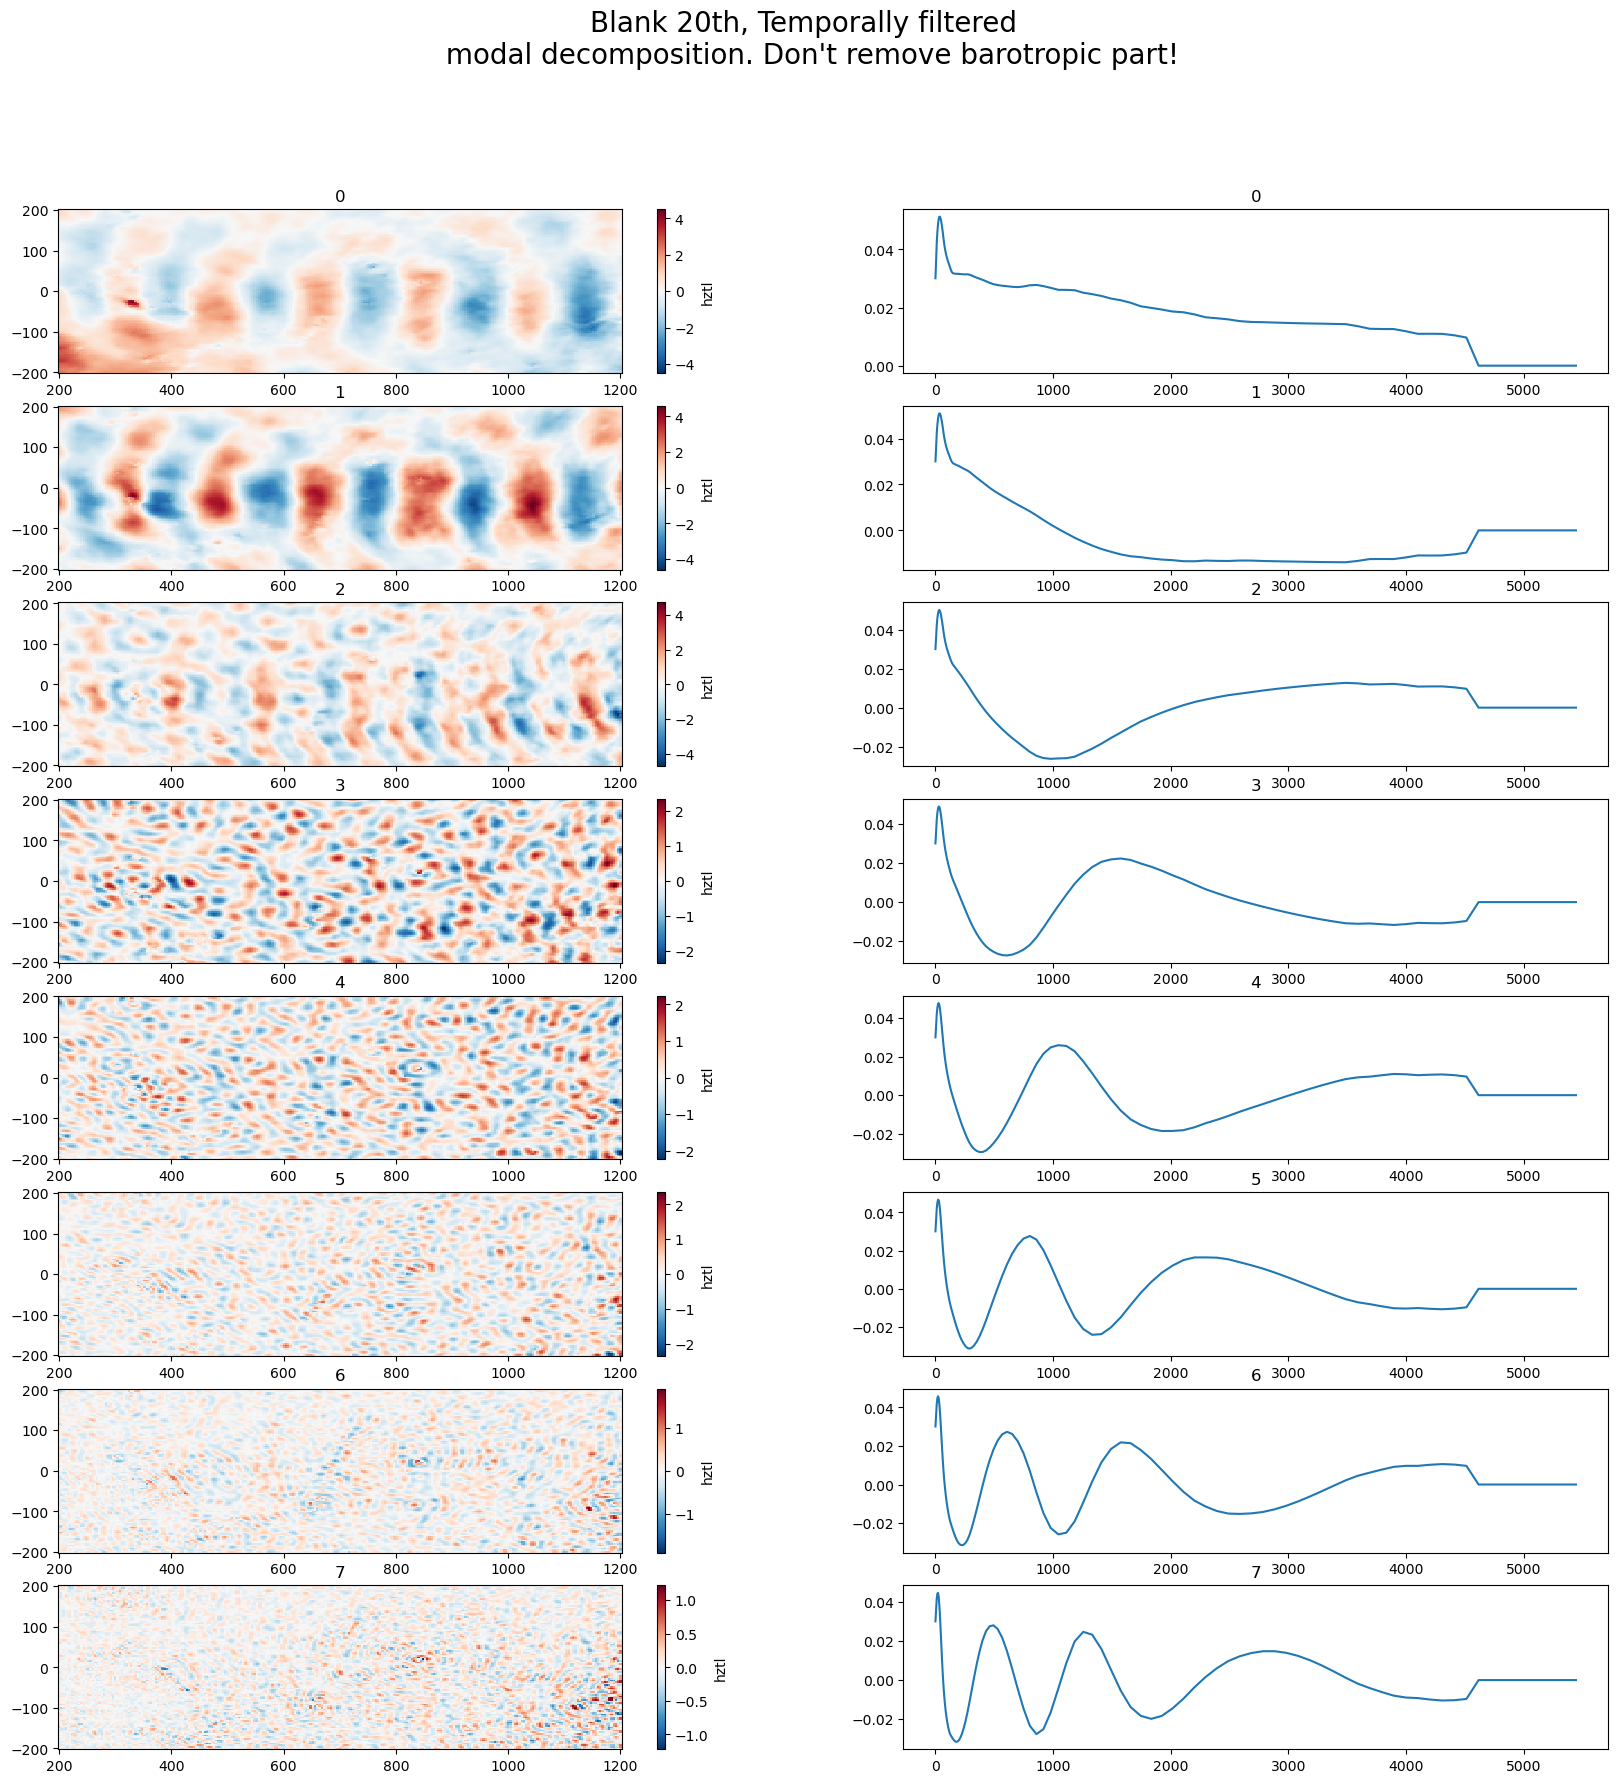

In [77]:
## Compare top down u snapshot
def plot_decomp(data):
    fig,ax = plt.subplots(8,2,figsize = (20,20))
    for i in range(8):
        (data.hztl.isel(time = 40)).isel(mode = i).sel(xb = slice(200,1200)).plot(ax = ax[i,0],add_colorbar = True)
        data.vrtl.isel(mode = i,yb = 25,xb = 200).plot(ax = ax[i,1])


        ax[i,0].set_xlabel("")
        ax[i,0].set_ylabel("")
        ax[i,0].set_title(i)
        ax[i,1].set_xlabel("")
        ax[i,1].set_ylabel("")
        ax[i,1].set_title(i)

    return fig
# ufull = VerticalModes(FullFiltered.isel(time = slice(0,5)),"u")
fig = plot_decomp(ublank)
# Increase font size of suptitle


fig.suptitle("Blank 20th, Temporally filtered \n modal decomposition. Don't remove barotropic part!",fontsize = 20)

In [89]:
KEfull.__xarray_dataarray_variable__

<xarray.DataArray '__xarray_dataarray_variable__' (mode: 10, zl: 81, yb: 51,
                                                   xb: 376)>
[15532560 values with dtype=float64]
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 3.284e+03 3.386e+03 3.487e+03
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -100.0 -96.0 -92.0 -88.0 ... 88.0 92.0 96.0 100.0
    lon      (yb, xb) float64 ...
    lat      (yb, xb) float64 ...
Dimensions without coordinates: mode

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_d

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
Task exception was never retrieved
future: <Task finished name='Task-7414072' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dis

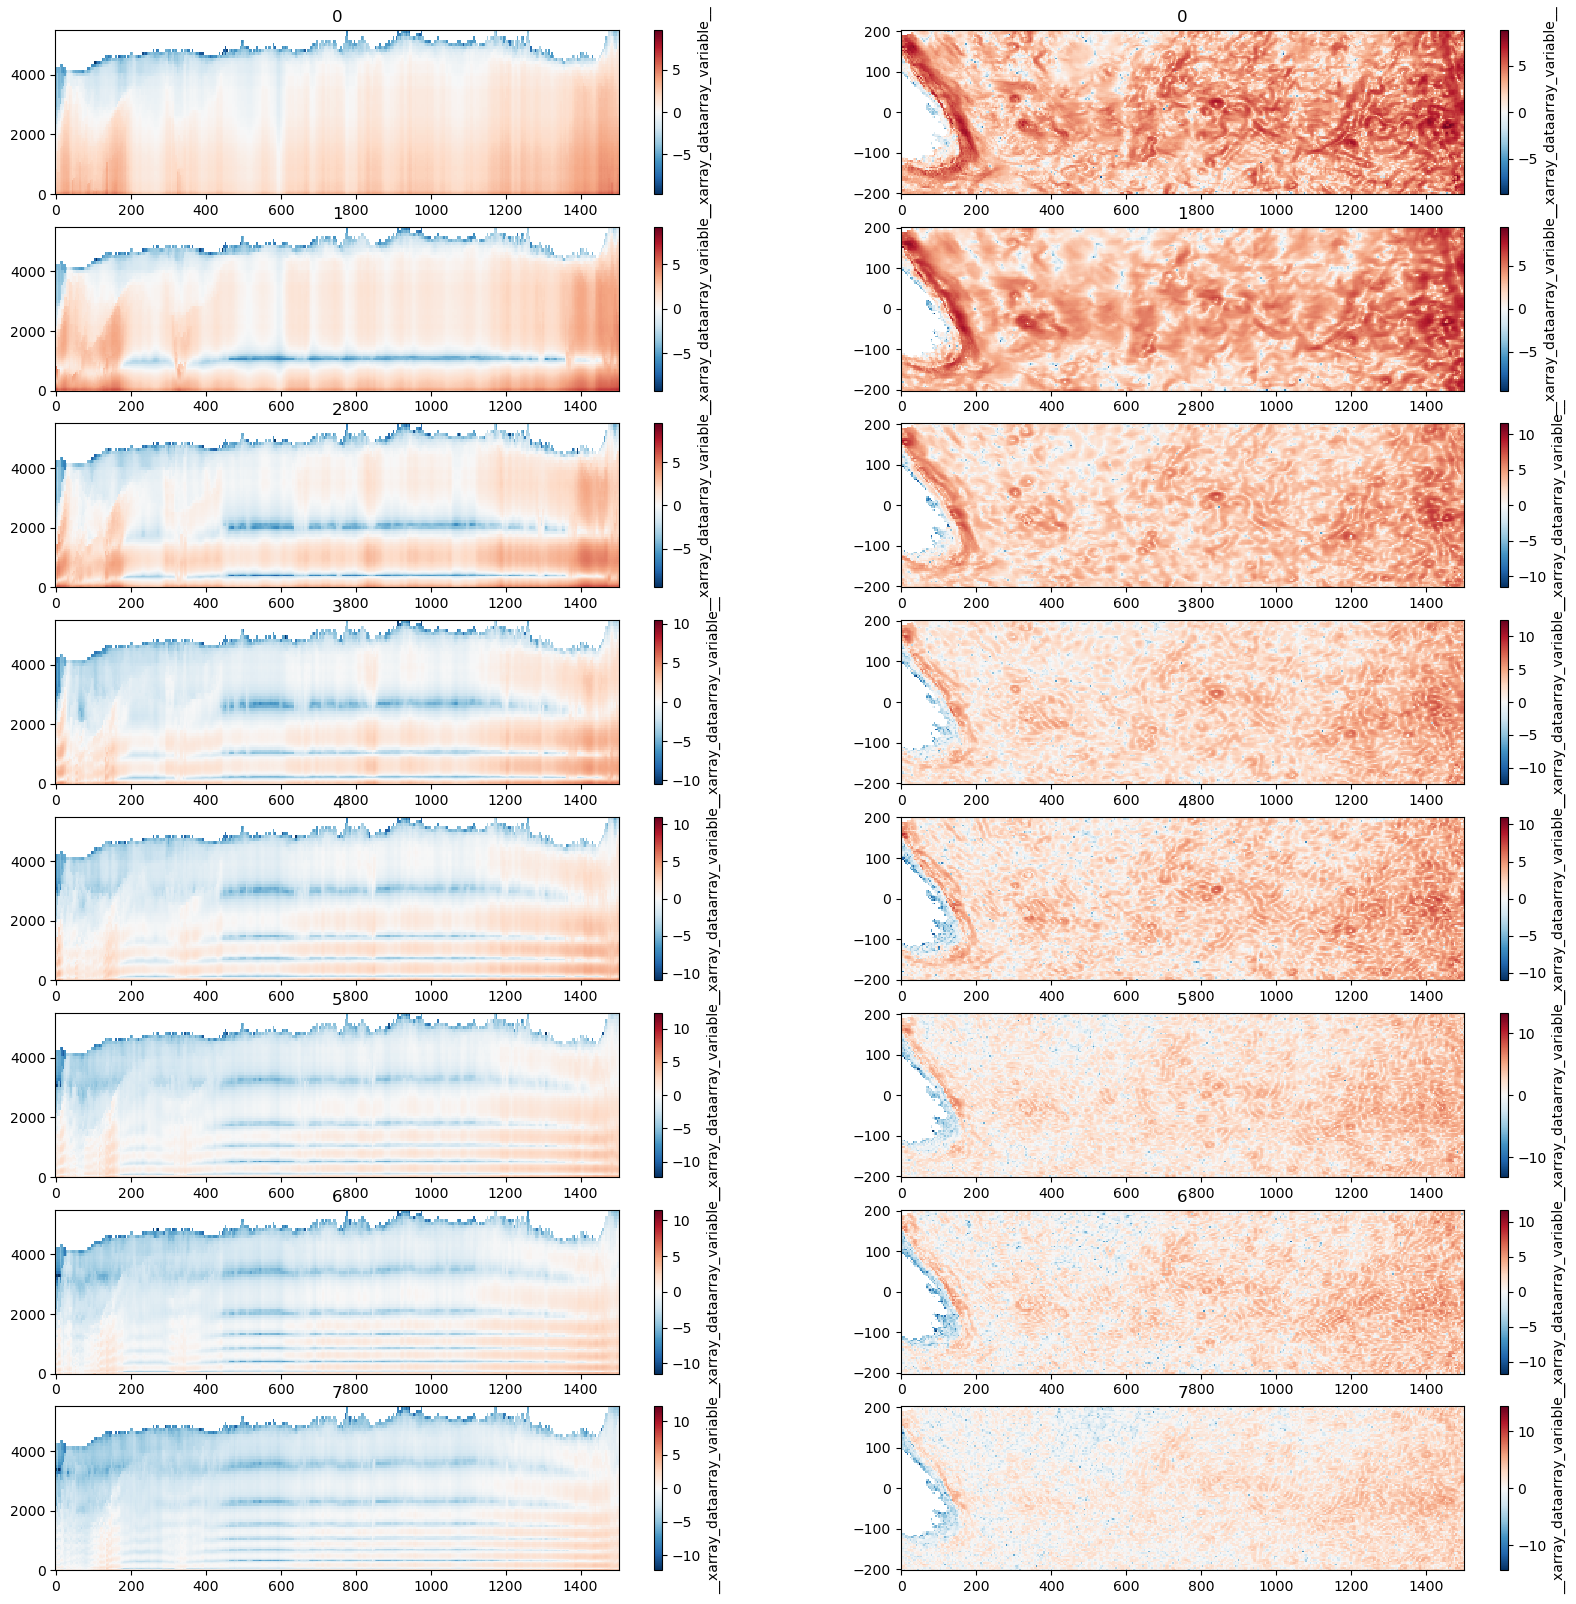

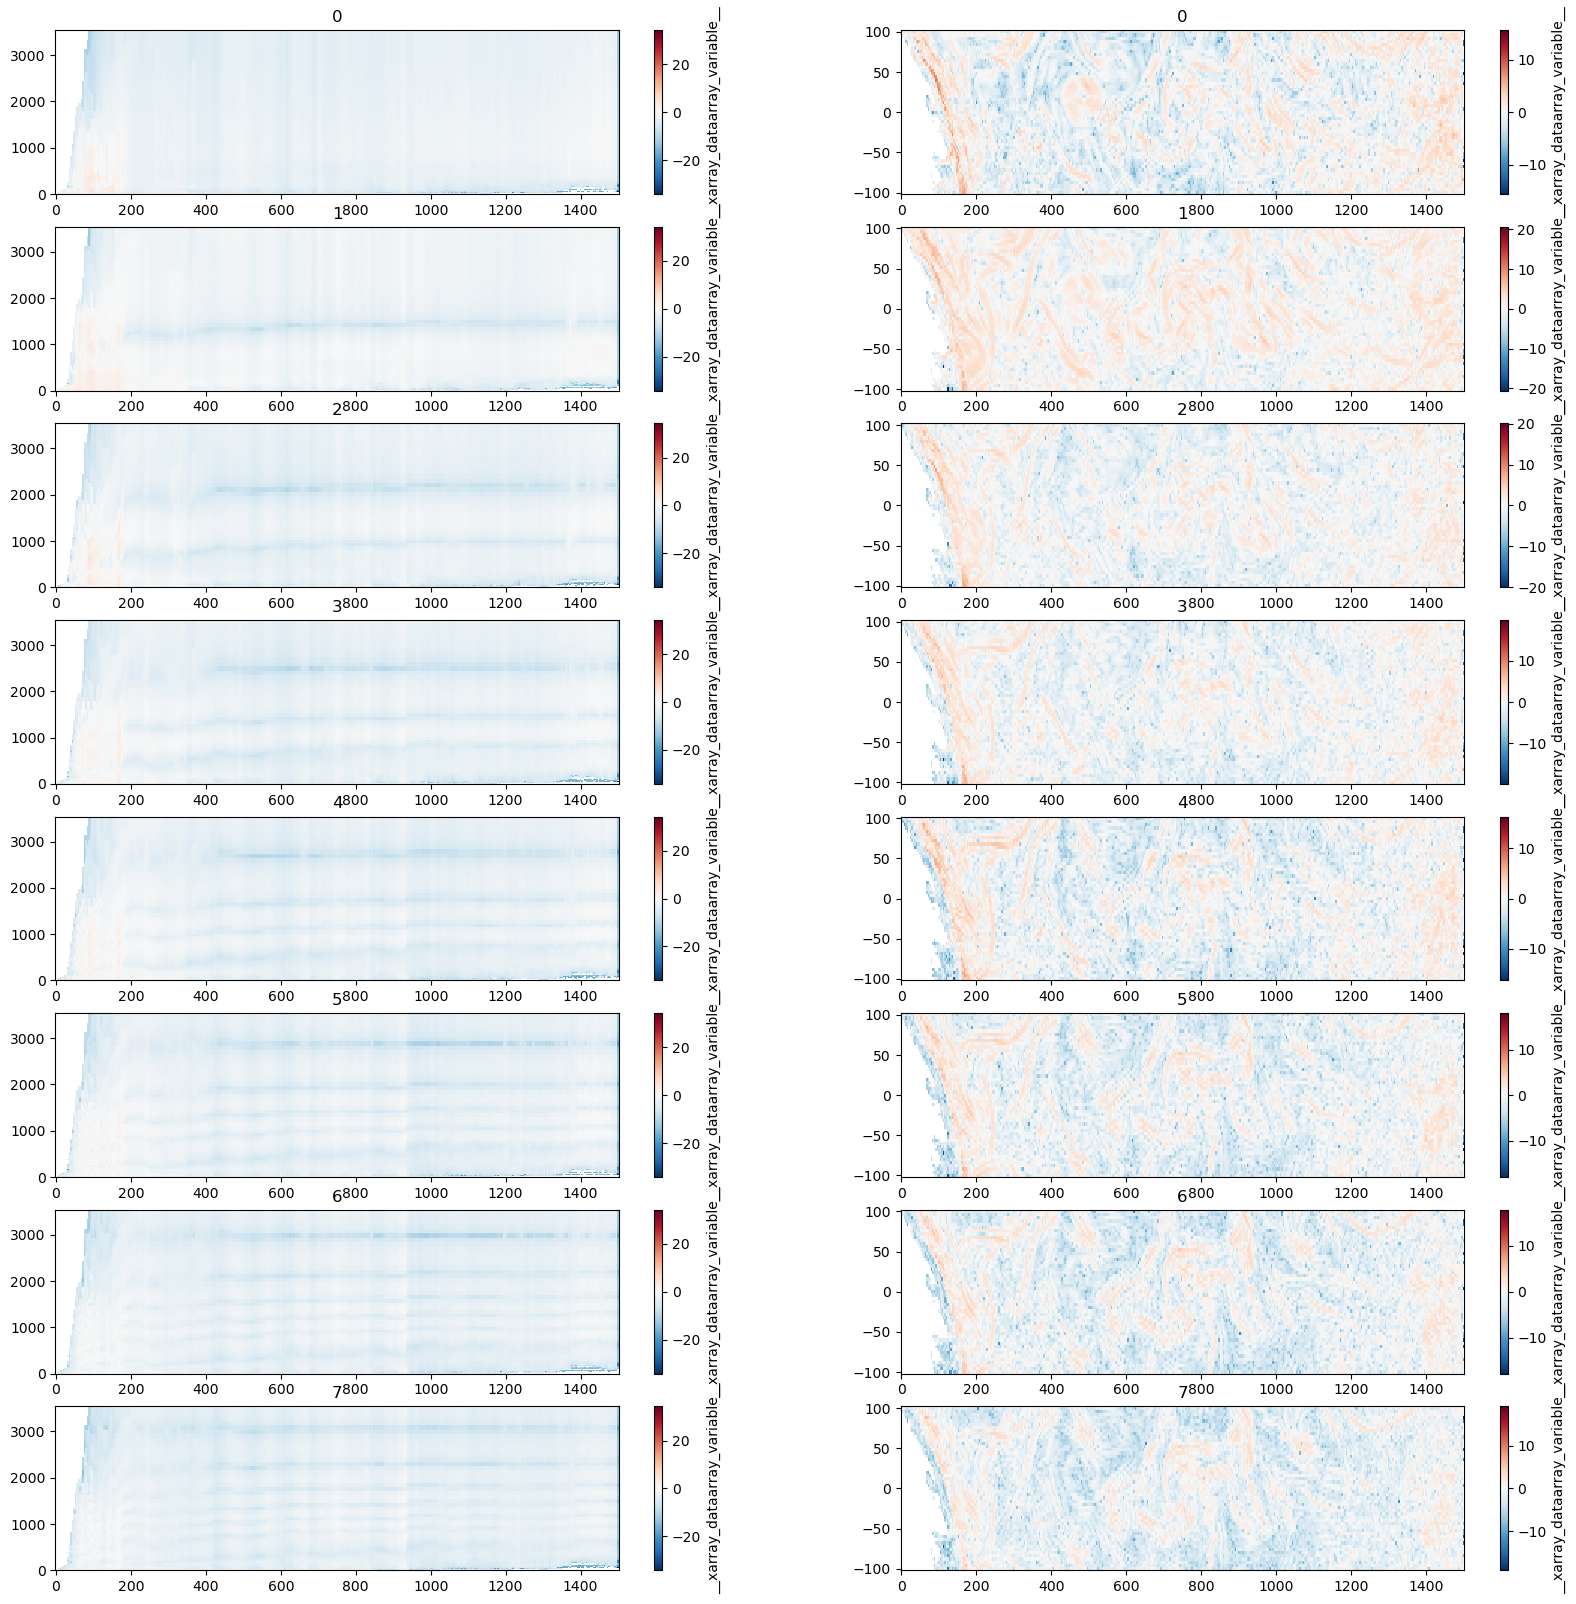

<Figure size 640x480 with 0 Axes>

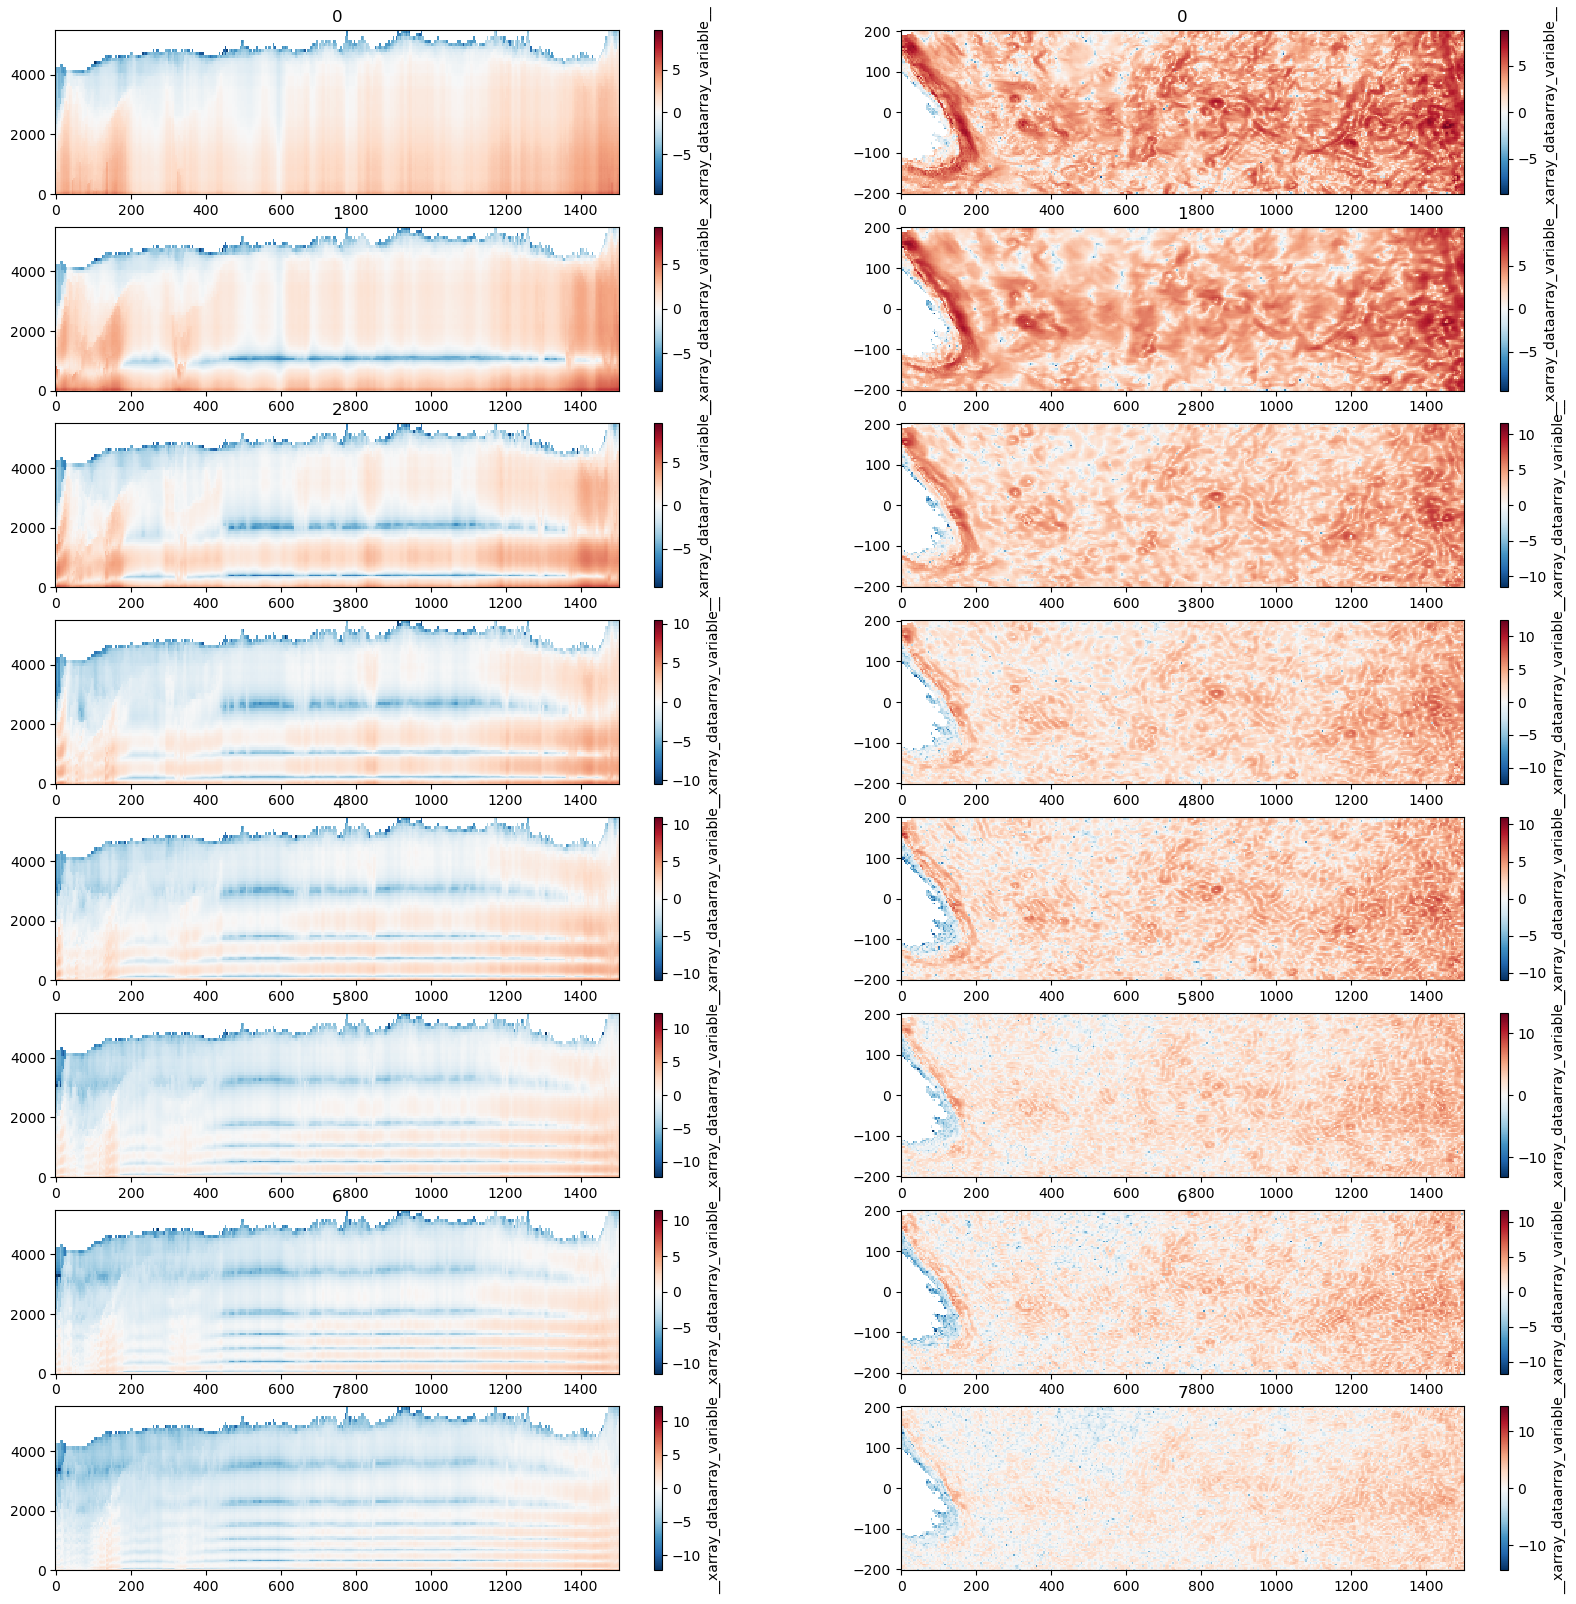

In [ ]:
def plot_KE(data):
    fig,ax = plt.subplots(8,2,figsize = (20,20))
    for i in range(8):
        data.isel(mode = i).integrate("yb").plot(ax = ax[i,0],add_colorbar = True)
        data.isel(mode = i).integrate("zl").plot(ax = ax[i,1],add_colorbar = True)
        ax[i,0].set_xlabel("")
        ax[i,0].set_ylabel("")
        ax[i,0].set_title(i)
        ax[i,1].set_xlabel("")
        ax[i,1].set_ylabel("")
        ax[i,1].set_title(i)

    return fig

plot_KE(KEfull.__xarray_dataarray_variable__)
plt.figure()
plot_KE(KEblank.__xarray_dataarray_variable__)

## Troubleshooting May 13 w/o Journal:

Had to integrate properly rather than taking averages! Xarray doesn't weight averages properly.